Compare with Bergen, Levy, Goodman (2016): pg. 29--31

In [20]:
:ext TypeSynonymInstances
:ext FlexibleInstances
:ext OverloadedStrings

In [21]:
import Data.Text (pack, Text)
import Data.Tuple.Extra (first)
import Data.List.Extra (dropEnd, subsequences, enumerate, (\\))
import Control.Monad.Trans.Class (lift)
import Control.Monad (liftM2)
import Data.IORef
import qualified Data.Map as Map

In [22]:
import Utils
import Tyche.Model
import Tyche.Dist
import Tyche.Prelude
import Tyche.Prob
import Tyche.Inference.Enumerate

In [23]:
import Graphics.Vega.VegaLite hiding (filter, lookup, repeat, FontWeight(Normal))
import qualified Graphics.Vega.VegaLite as VL (filter, lookup, repeat, FontWeight(Normal))

# Model

In [24]:
data Index = WNormal | WWeird deriving (Eq, Ord, Bounded, Enum)
instance Show Index where
  show WNormal = "w1"
  show WWeird = "w2"
type Prop = [Index]
universe :: [Index]
universe = enumerate

# Language

In [25]:
data Utt = UNone | UMarked | UUnmarked deriving (Eq, Ord, Bounded, Enum)
instance Show Utt where
  show UNone = "silence"
  show UMarked = "marked"
  show UUnmarked = "unmarked"
utterances :: [Utt]
utterances = enumerate

In [26]:
data Lexicon = Lex {lexID :: Int, den :: Utt -> Prop}

instance Show Lexicon where
  show (Lex _ f) = "M = " ++ show (f UMarked) ++ "; U = " ++ show (f UUnmarked)
instance Eq Lexicon where
  (Lex m _) == (Lex n _) = m == n
instance Ord Lexicon where
  (Lex m _) <= (Lex n _) = m <= n

## Rational Agents

In [27]:
-- Initialize reference cell for storing results to share within and between computations
type Cache = IORef (Int, Map.Map (Int, Utt, Lexicon) (Dist Index))
cacheRef <- newIORef (0, Map.empty) :: IO Cache

An $n$-level agent reasoning about `a` given `k` is a graphical model (supplemented with a memory, for efficiency)
- if the problem is old, the posterior distribution is returned from memory
- if the problem is new, then priors over indices, messages, and lexica are fed to a node computing the posterior distribution over `a`

In [28]:
data Priors = Priors {ip :: Model Index, up :: Model Utt, lp :: Model Lexicon}
type Agent k a = Priors -> Cache -> (Int, k, Lexicon) -> Model a

* A speaker trying to describe index $i$ is an agent that chooses an utterance $u$ in proportion to its prior probability (itself determined by the markedness of the utterance) and the likelihood that a listener would choose $i$ upon hearing $u$
* A listener trying to interpret an utterance $u$ is an agent that chooses an index $i$ in proportion to its prior probability and the likelihood that a speaker would choose $u$ upon trying to describe $i$

In [29]:
alpha :: Double
alpha = 4

speaker :: Agent Index Utt
speaker priors ref (n,i,l) =
  do u <- up priors
     if null (den l u)
       then weight negInf
       else do lnr <- lift $ memoize ref (fmap fst . listener priors ref) (n-1,u,l)
               weight $ alpha * logProb lnr i
     return u

listener :: Agent Utt (Index, Lexicon)
listener priors ref (n,u,l)
  | n > 0 =
      do index  <- ip priors
         interp <- if n == 1 then lp priors else return l
         spr    <- lift . enumD $ speaker priors ref (n,index,interp)
         observe spr u
         return (index, interp)
  | otherwise =
      do index  <- ip priors
         condition (index `elem` den l u)
         return (index, l)

# Priors

In [30]:
indicesPrior :: Model Index
indicesPrior = categorical [(WNormal, 0.667), (WWeird, 0.333)]

In [31]:
mBarFromDist :: (Ord a, Show a) => Text -> Bool -> Dist a -> VegaLite
mBarFromDist ys xs m =
  let (vs,ps) = unzip (toList m)
      dvals = dataFromColumns []
              . dataColumn "outcome" (Strings $ fmap (pack . show) vs)
              . dataColumn "probability" (Numbers $ fmap exp ps)

      enc = encoding
            . position X [ PName "outcome", PmType Ordinal
                         , PAxis [AxLabelAngle (-55), AxNoTitle, AxLabels xs]
                         , PScale [SRangeStep (Just 30)], PSort []
                         ]
            . position Y [ PName "probability", PmType Quantitative
                         , PAxis [AxTitle ys, AxTitleAngle 0, AxTitleAlign AlignRight]
                         , PScale [SDomain (DNumbers [0,1])]
                         ]
            . color [MName "outcome", MmType Nominal, MLegend []]

  in toVegaLite [description "", dvals [], mark Bar [], enc [], height 75]

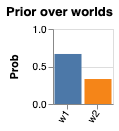

In [32]:
vlShow . titled "Prior over worlds" . mBarFromDist "Prob" True <$> enumD indicesPrior

In [33]:
cost :: Utt -> Double
cost UNone = 5
cost UMarked = 2
cost UUnmarked = 1

In [34]:
utterancePrior :: Model Utt
utterancePrior = belief . fromList $ [(u, - alpha * cost u) | u <- utterances]

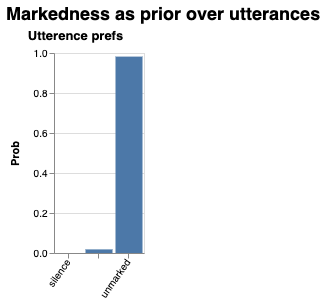

In [35]:
addTitle s v = toVegaLite [title (pack s) [TFontSize 18], vConcat [fromVL v]]
vlShow . addTitle "Markedness as prior over utterances" . sidewaysDists <$> sequence
  [ titled "Utterence prefs" . barFromDist <$> enumD utterancePrior
  -- , titled "Prefs if forced to speak" . barFromDist <$>
  --     enumD (utterancePrior >>= \u -> condition (u /= UNone) >> return u)
  ]

# Lexical uncertainty

In [36]:
den0 :: Lexicon
den0 = Lex 0 f
  where f _ = universe

dens :: [Lexicon]
dens = zipWith ($) lexes [1..]
 where
  lexes = do u <- subsequences universe \\ [[]]
             m <- subsequences universe \\ [[]]
             let f UNone = universe
                 f UUnmarked = u
                 f UMarked = m
             return $ \d -> Lex d f

# Experiment

In [37]:
infoBaseline = Priors indicesPrior utterancePrior (unif [den0])
infoLUM = infoBaseline {lp = unif dens}

Line 9: Use head
Found:
ys !! 0
Why not:
head ysLine 10: Use head
Found:
ys !! 0
Why not:
head ys

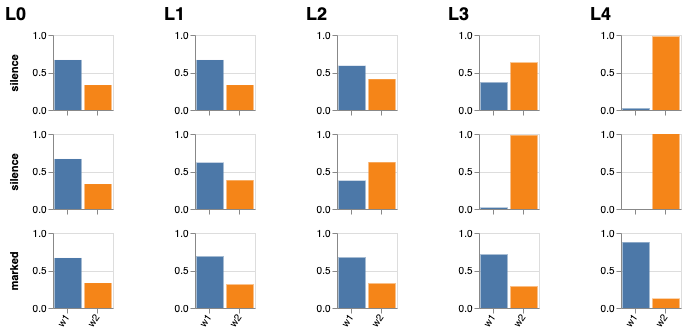

In [40]:
writeIORef cacheRef (0, Map.empty)

mkGraph ys (t, l, m, n) = do
  barl <- enumD (fst <$> l)
  barm <- enumD (fst <$> m)
  barn <- enumD (fst <$> n)
  return $ toVegaLite
    [ center True
    , vConcat [ fromVL (mBarFromDist (ys !! 0) False barl)
              , fromVL (mBarFromDist (ys !! 0) False barm)
              , fromVL (mBarFromDist (ys !! 1) True  barn)
              ]
    , title (pack t) [TFontSize 18]
    ]
    
graphs = liftM2 (:)
  ( mkGraph ["silence", "marked", "unmarked"]
        ("L0"
        , listener infoLUM cacheRef (0, UNone, den0)
        , listener infoLUM cacheRef (0, UMarked, den0)
        , listener infoLUM cacheRef (0, UUnmarked, den0)
        )
  )
  ( traverse (mkGraph ["", "", ""])
      [ ("L1"
        , listener infoLUM cacheRef (1, UNone, den0)
        , listener infoLUM cacheRef (1, UMarked, den0)
        , listener infoLUM cacheRef (1, UUnmarked, den0)
        )
      , ("L2"
        , listener infoLUM cacheRef (2, UNone, den0)
        , listener infoLUM cacheRef (2, UMarked, den0)
        , listener infoLUM cacheRef (2, UUnmarked, den0)
        )
      , ("L3"
        , listener infoLUM cacheRef (3, UNone, den0)
        , listener infoLUM cacheRef (3, UMarked, den0)
        , listener infoLUM cacheRef (3, UUnmarked, den0)
        )
      , ("L4"
        , listener infoLUM cacheRef (4, UNone, den0)
        , listener infoLUM cacheRef (4, UMarked, den0)
        , listener infoLUM cacheRef (4, UUnmarked, den0)
        )
      ]
  )

vlShow . sidewaysDists <$> graphs